# Sentinel Data Query, Filtering, Visualization, and Excel Export using STAC API

This Jupyter Notebook provides a complete end-to-end workflow for accessing and analyzing Sentinel satellite imagery using the STAC (SpatioTemporal Asset Catalog) API from the Copernicus Data Space Ecosystem. It walks through each step from connecting to the STAC API and defining a geographic area of interest (AOI), to querying data with cloud cover constraints, filtering by specific tile ids, and visualizing the results.

The process includes:
- Metadata extraction.
- Visualization of tiles distributions.
- Filtering based on user-defined tile IDs.
- Exporting the final dataset to a dynamically named Excel file.

The example focuses on Laos, a Southeast Asian country, and retrieves data for the time period January to December 2022 with cloud cover ranging from 0% to 30%.


## Prerequisites
Ensure you have the following libraries installed:
```bash
!pip install pandas pystac_client folium openpyxl matplotlib seaborn
```
If using Jupyter or Colab, prefix the command with `!`.

## 1️⃣ Import Libraries and Set Environment
```python
Import all necessary libraries

In [4]:
import os
import re
import pandas as pd
import folium
from pprint import pprint
import pystac_client
import matplotlib.pyplot as plt
import seaborn as sns

## 2️⃣ Connect to STAC API and Define Area of Interest (AOI)
Connect to the Copernicus STAC catalog, available at the endpoint: https://stac.dataspace.copernicus.eu/v1.

In [6]:
# Define the STAC endpoint
URL = "https://stac.dataspace.copernicus.eu/v1"
cat = pystac_client.Client.open(URL)
cat.add_conforms_to("ITEM_SEARCH")

In [7]:
# Define the polygon geometry (Laos bounding box example)
geom = {
    "type": "Polygon",
    "coordinates": [[
        [99.96955135929616, 17.41815441162028],
        [99.96955135929616, 22.57651155257228],
        [103.06848834891751, 22.57651155257228],
        [103.06848834891751, 17.41815441162028],
        [99.96955135929616, 17.41815441162028],
    ]]
}

We define the area as a polygon based on geographical coordinates in GeoJSON format.
* `type`: Geometry type, in this case, a polygon.
* `coordinates`: A list of coordinates defining the area.

## 3️⃣ Visualize AOI with Folium
```python

In [10]:
center_lat = sum([pt[1] for pt in geom["coordinates"][0]]) / len(geom["coordinates"][0])
center_lon = sum([pt[0] for pt in geom["coordinates"][0]]) / len(geom["coordinates"][0])
m = folium.Map(location=[center_lat, center_lon], zoom_start=10)
folium.GeoJson(geom, style_function=lambda x: {
    'fillColor': 'blue', 'color': 'blue', 'weight': 2, 'fillOpacity': 0.3
}).add_to(m)
m  # This displays the interactive map

## 4️⃣ Search Sentinel Data with Parameters

In this section, we define and combine parameters into a single dictionary for passing to the search function:

* `max_items`: The maximum number of results to retrieve.
* `collections`: The STAC collection (e.g., Sentinel-2 Level 2A data).
* `datetime`: Time range in YYYY-MM-DD/YYYY-MM-DD format.
* `intersects`: The previously defined area of interest.
* `query`: Filters results by metadata properties (e.g., `{"eo:cloud_cover": {"gte": 0, "lte": 30}}` returns items with cloud cover between 0% and 30%).
* `sortby`: Sorts results (e.g., by the eo:cloud_cover property in ascending order).
* `fields`: Specifies which fields to exclude (e.g., geometry).

#### Examples of Other Sentinel Collections You Can Use:
- `sentinel-1-grd`: Ground Range Detected (GRD) radar products.
- `sentinel-3-olci`: Ocean and Land Colour Instrument.
- `sentinel-5p`: Sentinel-5 Precursor for atmospheric composition.
- `sentinel-2-l1c`: Level-1C top-of-atmosphere reflectance data.
- `sentinel-1-slc`: Single Look Complex radar data.

Change the `collections` value to query other missions as needed.

In [12]:
params = {
    "max_items": 500,
    "collections": "sentinel-2-l2a",
    "datetime": "2022-01-01/2022-12-31",
    "intersects": geom,
    "query": {"eo:cloud_cover": {"gte": 0, "lte": 30}},
    "sortby": "properties.eo:cloud_cover",
    "fields": {"exclude": ["geometry"]},
}

items = list(cat.search(**params).items_as_dicts())
print(f"Number of items found: {len(items)}\n")

Number of items found: 500



In [13]:
summary_data = []
for i, item in enumerate(items, 1):
    product_id = item.get("id", "")
    datetime_val = item.get("properties", {}).get("datetime", "")
    tile_id = item.get("properties", {}).get("s2:tile_id", "")
    cloud = item.get("properties", {}).get("eo:cloud_cover", "N/A")
    asset = item.get("assets", {}).get("AOT_10m", {})
    download_url = asset.get("alternate", {}).get("https", {}).get("href", "N/A")

    summary_data.append({
        "S.No": i,
        "Product ID": product_id,
        "Date Acquired": datetime_val[:10],
        "Cloud Cover (%)": cloud,
        "Download URL": download_url
    })

In [14]:
# Convert to DataFrame
df = pd.DataFrame(summary_data)

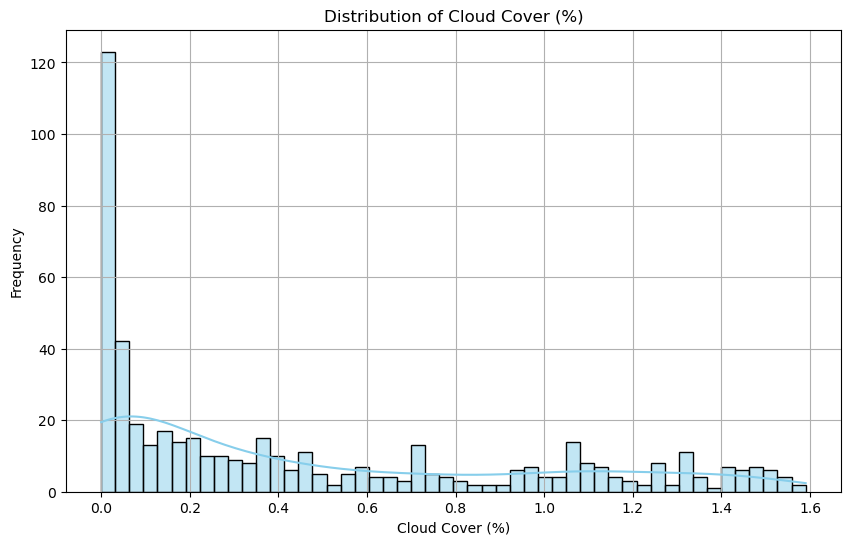

In [15]:
# Visualization of cloud cover distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Cloud Cover (%)'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Cloud Cover (%)')
plt.xlabel('Cloud Cover (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## 5⃣ Extract Tile ID from Product ID and Plot Tile ID by Frequency
```python

In [17]:
def extract_title_from_product_id(text):
    if pd.isna(text):
        return ''
    matches = re.findall(r'_T[a-zA-Z0-9]{5}_', str(text))
    return matches[0].strip('_') if matches else ''

df['Tile ID'] = df['Product ID'].apply(extract_title_from_product_id)

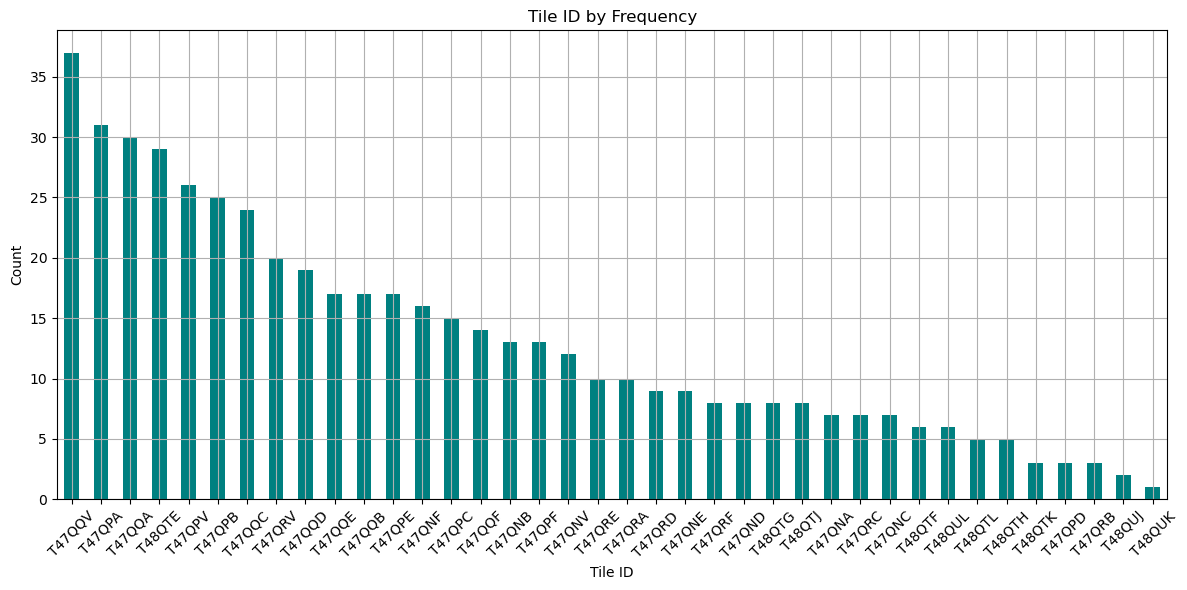

In [18]:
# Count of items by tile id
plt.figure(figsize=(12, 6))
df['Tile ID'].value_counts().plot(kind='bar', color='teal')
plt.title('Tile ID by Frequency')
plt.xlabel('Tile ID')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## 6⃣ Filter Data by Specific Tile IDs and Plot Cloud Cover Distribution
```python

In [20]:
# Define tile IDs of interest
names_to_keep = [
    'T47QQA', 'T47QQB', 'T47QQC', 'T47QQD', 'T47QQE'
]

# Filter based on Tile ID
filtered_df = df[df['Tile ID'].isin(names_to_keep)]

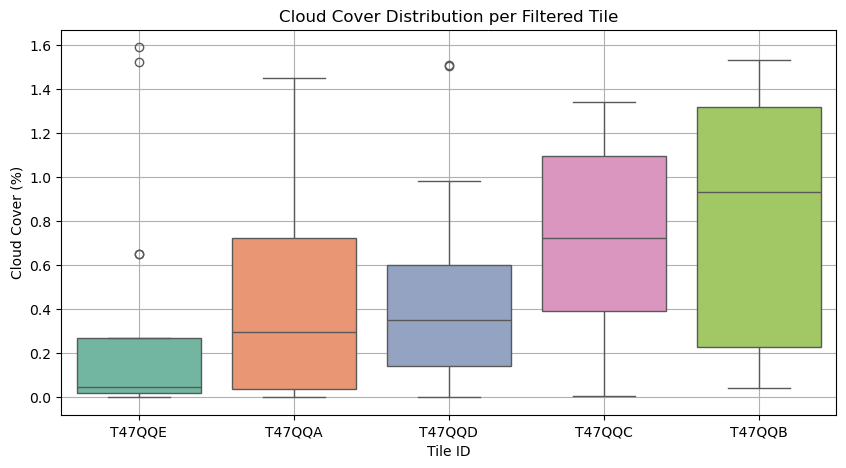

In [21]:
# Plot filtered tile cloud cover
plt.figure(figsize=(10, 5))
sns.boxplot(data=filtered_df, x='Tile ID', y='Cloud Cover (%)', hue='Tile ID', palette='Set2', legend=False)
plt.title('Cloud Cover Distribution per Filtered Tile')
plt.xlabel('Tile ID')
plt.ylabel('Cloud Cover (%)')
plt.grid(True)
plt.legend([],[], frameon=False)  # Ensure no empty legend
plt.show()

## 7⃣ Export Final Filtered Data to Excel
```python

In [23]:
# Use the collection name from the search parameters to create a dynamic filename
collection_name = params.get("collections", "output").replace("/", "-")  # Replace slashes if any
output_file = f"{collection_name}_final_filtered.xlsx"

# Export to Excel
filtered_df.to_excel(output_file, index=False)
print(f"Final filtered data saved to '{output_file}'")


Final filtered data saved to 'sentinel-2-l2a_final_filtered.xlsx'


## Output File
- `sentinel2-2-l2a_final_filtered.xlsx`: The final Excel output file is dynamically named with the queried Sentinel collection as a prefix (e.g., sentinel-2-l2a_final_filtered.xlsx), clearly indicating the satellite product and filtering applied in the dataset.

## Notes
- This notebook helps monitor and manage sentinel satellite data over area of interest.
- Replace keys and regions to customize it for your project.
- Can be extended to download imagery, visualize time series, or compute NDVI and other metrics.